In [1]:
import duckdb
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [2]:
con = duckdb.connect()

project_root = Path.cwd().parent
games_path = project_root/"out"/"cleaned_games"
terminations_path = project_root/"out"/"terminations"

In [3]:
query = f"""
CREATE OR REPLACE VIEW games_clean AS
SELECT *
FROM parquet_scan('{games_path}/*.parquet') AS g
JOIN parquet_scan('{terminations_path}/*.parquet') AS t
  ON g.game_id = t.game_id
"""

con.execute(query)

In [4]:
query = f"""
SELECT COUNT(*) FROM games_clean
"""
con.execute(query).fetchall()

[(9944717,)]

In [5]:
binsize = 50
query = f"""
SELECT
    CAST(((white_elo + black_elo)/2 / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
    COUNT(*) AS total_games,
    SUM(CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END) AS draws
FROM games_clean
GROUP BY elo_bin
ORDER BY elo_bin

"""
df = con.execute(query).fetchdf()

In [6]:
rolling_bins = 10
min_games_per_bin = 200

df['draw_rate'] = df['draws'] / df['total_games']
# Smooth with rolling average
df['draw_rate_smooth'] = (
    (df['draw_rate'] * df['total_games'])
    .rolling(window=rolling_bins, center=True, min_periods=1)
    .sum() /
    df['total_games'].rolling(window=rolling_bins, center=True, min_periods=1).sum()
)

df_plot = df[df['total_games'] >= min_games_per_bin]

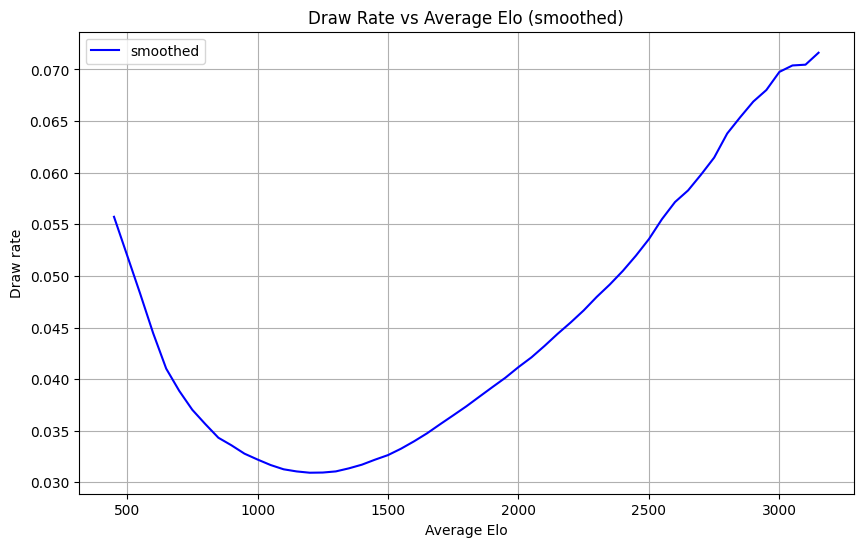

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_plot['elo_bin'], df_plot['draw_rate_smooth'], color='blue', label='smoothed')
plt.xlabel('Average Elo')
plt.ylabel('Draw rate')
plt.title('Draw Rate vs Average Elo (smoothed)')
plt.grid(True)
plt.legend()
plt.show()

Interesting behaviour.... draws increase at higher level as expected due to more accurate play, however draws also seem to increase at lower level. lets split into draws by time control

In [8]:
time_controls = ("Classical", "Rapid","Blitz","Bullet","UltraBullet","Correspondence","Other")
tc_list_sql = ",".join([f"'{t}'" for t in time_controls])

In [ ]:
def plot_separate_tc(y, yname = 'rate'):
    
    df[yname] = df[y] / df['total_games']

    def weighted_smooth_group(g, window=rolling_bins):
        g = g.sort_values('elo_bin').reset_index(drop=True)
        # columns needed
        rate = g[yname]
        n = g['total_games']
        # weighted rolling: numerator = sum(rate * n), denom = sum(n)
        num = (rate * n).rolling(window=window, center=True, min_periods=1).sum()
        denom = n.rolling(window=window, center=True, min_periods=1).sum()
        g[f'Smoothed {yname}'] = num / denom
        return g

    df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))
    
    plt.figure(figsize=(12,7))

    min_games_per_bin = 10

    colours = {
        "Classical":"#9467bd",
        "Rapid":"#d62728",
        "Blitz":"#2ca02c",
        "Bullet":"#ff7f0e",
        "UltraBullet":"#1f77b4",
    }

    legend_handles = []
    legend_labels = []

    for tc in time_controls:
        if tc != "Correspondence":
            g = df_smoothed[df_smoothed['time_control'] == tc].sort_values('elo_bin')
            if g.empty:
                continue

            # mask (exclude) bins with too few games
            g_plot = g[g['total_games'] >= min_games_per_bin]

            if g_plot.empty:
                # nothing to plot for this TC (all bins too small) -> skip plotting entirely
                continue

            # plot the (masked) smoothed line
            h, = plt.plot(
                g_plot['elo_bin'],
                g_plot[f'Smoothed {yname}'],
                label=tc,
                linewidth=2,
                color=colours.get(tc, 'k'),
                zorder=2
            )


            
            # record handle/label in order so legend respects this order
            legend_handles.append(h)
            legend_labels.append(tc)

    # now create legend using the collected handles in that order
    plt.legend(legend_handles, legend_labels, title='Time control', loc='best')

    plt.xlabel('Average Elo')
    plt.ylabel(f'{yname}')
    plt.title(f'{yname} vs Average Elo by time control (binsize={binsize}, window={rolling_bins})')
    plt.grid(True)
    plt.show()

In [10]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END AS is_draw,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(is_draw) AS draws,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_10124\584562980.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


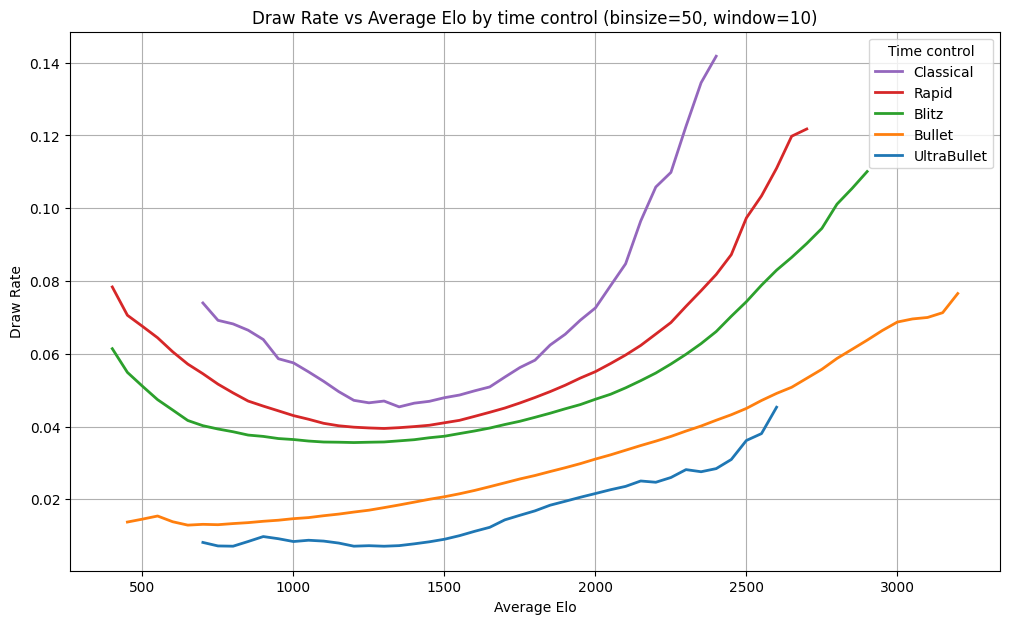

In [11]:
plot_separate_tc('draws', 'Draw Rate')

okay we see in the faster gamemodes (Bullet and UltraBullet) we still see an increase at the higher levels but not at the lower levels. lets have a look at how draws occured across rating ranges across time controls....

lets first have a look at all the different ways games can be drawn on lichess to see what will contribute the most

In [12]:
query = f"""
SELECT
    end_reason,
    COUNT(*) AS count,
FROM games_clean
WHERE result = '1/2-1/2'
GROUP BY end_reason
ORDER BY count DESC
"""
df = con.execute(query).fetchdf()

4               threefold_repetition
5       timeout_draw_by_insufficient
3                          stalemate
1    insufficient_material_automatic
0                     agreement_draw
2                              other
Name: end_reason, dtype: object


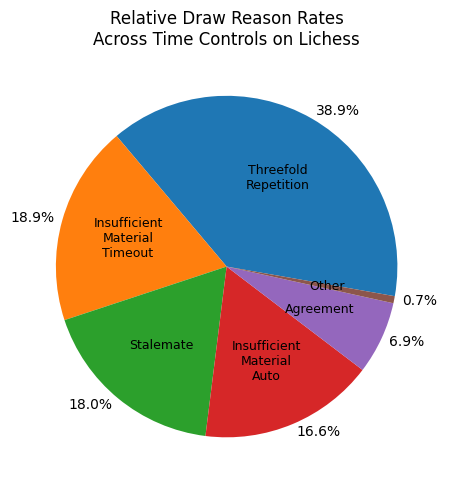

In [13]:
df["end_reason"] = df["end_reason"].replace(
    {"fifty_move_rule": "other", "insufficient_material_claimed": "other"}
)
df = (
    df.groupby("end_reason", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
)

sizes = df["count"].to_numpy()

print(df["end_reason"])

# compute corrected percents so they add to 100
percentages = 100.0 * sizes / sizes.sum()
scaled = percentages * 10.0
floor_units = np.floor(scaled).astype(int)
remainders = scaled - floor_units
units = floor_units.copy()
remaining = int(round(1000 - units.sum()))
if remaining > 0:
    idxs = np.argsort(remainders)[::-1][:remaining]
    for i in idxs:
        units[i] += 1
elif remaining < 0:
    idxs = np.argsort(remainders)[: abs(remaining)]
    for i in idxs:
        units[i] -= 1
pct_display = units / 10.0

endings_map = {
    "threefold_repetition":"Threefold\nRepetition",
    "timeout_draw_by_insufficient":"Insufficient\nMaterial\nTimeout",
    "stalemate": "Stalemate",
    "insufficient_material_automatic":"Insufficient\nMaterial\nAuto",
    "agreement_draw": "Agreement",
    "other": "Other"
    }

labels = df["end_reason"].map(endings_map).fillna(df["end_reason"]).tolist()
#plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Relative Draw Reason Rates\nAcross Time Controls on Lichess")

wedges, _ = ax.pie(sizes, labels=[None]*len(sizes), startangle=360 - 10)

# inside-label radius and outside-percent radius
r_label = 0.6
r_pct = 1.05

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    # inside label position
    x_label = r_label * np.cos(np.deg2rad(angle))
    y_label = r_label * np.sin(np.deg2rad(angle))
    ax.text(
        x_label, y_label, labels[i],
        ha="center", va="center", fontsize=9, wrap=True
    )

    # outside percent position
    x_pct = r_pct * np.cos(np.deg2rad(angle))
    y_pct = r_pct * np.sin(np.deg2rad(angle))
    ha = "left" if x_pct >= 0 else "right" # need to align based on side
    ax.text(
        x_pct, y_pct, f"{pct_display[i]:.1f}%",
        ha=ha, va="center", fontsize=10
    )

fig.tight_layout()


In [14]:
import re
import numpy as np
import matplotlib.pyplot as plt

def plot_selected_endings_vs_elo(
    con,
    endings_map,
    binsize=50,
    rolling_bins=11,
    min_games_per_bin=200,
    figsize=(10, 6),
):
    
    endings = list(endings_map.keys())





    # SQL: map the two endings into 'other' first, then aggregate counts per mapped_end_reason
    # using a subquery so we mirror your df.replace() behaviour.
    select_cols = [
        f"CAST(((white_elo + black_elo)/2 / {binsize}) AS INTEGER) * {binsize} AS elo_bin",
        "COUNT(*) AS total_games",
    ]
    for e in endings:
        select_cols.append(
            f"SUM(CASE WHEN mapped_end_reason = '{e}' THEN 1 ELSE 0 END) AS {e}"
        )
    
    select_block = ',\n        '.join(select_cols)
    
    query = f"""
    SELECT
        {select_block}
    FROM (
        SELECT
            *,
            CASE
                WHEN end_reason IN ('fifty_move_rule','insufficient_material_claimed') THEN 'other'
                ELSE end_reason
            END AS mapped_end_reason
        FROM games_clean
    ) t
    GROUP BY elo_bin
    ORDER BY elo_bin
    """

    df = con.execute(query).fetchdf()

    # sort, reset index
    df = df.sort_values("elo_bin").reset_index(drop=True)

    # rolling denom (weighted by games)
    denom_roll = df["total_games"].rolling(window=rolling_bins, center=True, min_periods=1).sum()

    # prepare plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel("Average Elo")
    ax.set_ylabel("Rate (%)")
    ax.set_title("Ending-type Rate vs Average Elo (smoothed)")
    ax.grid(True)

    any_plotted = False
    for e in endings:
        # rolling sum of counts for this ending
        num_roll = df[e].rolling(window=rolling_bins, center=True, min_periods=1).sum()
        smoothed_rate = np.where(denom_roll > 0, num_roll / denom_roll, np.nan)

        mask = df["total_games"] >= min_games_per_bin
        x = df.loc[mask, "elo_bin"]
        y = smoothed_rate[mask.values] * 100.0  # percent

        ax.plot(x, y, label=endings_map.get(e, e))

    ax.legend(loc = "upper center", bbox_to_anchor = (0.3, 1))
    ax.set_ylim(bottom=0)  # sensible floor
    plt.tight_layout()
    plt.show()


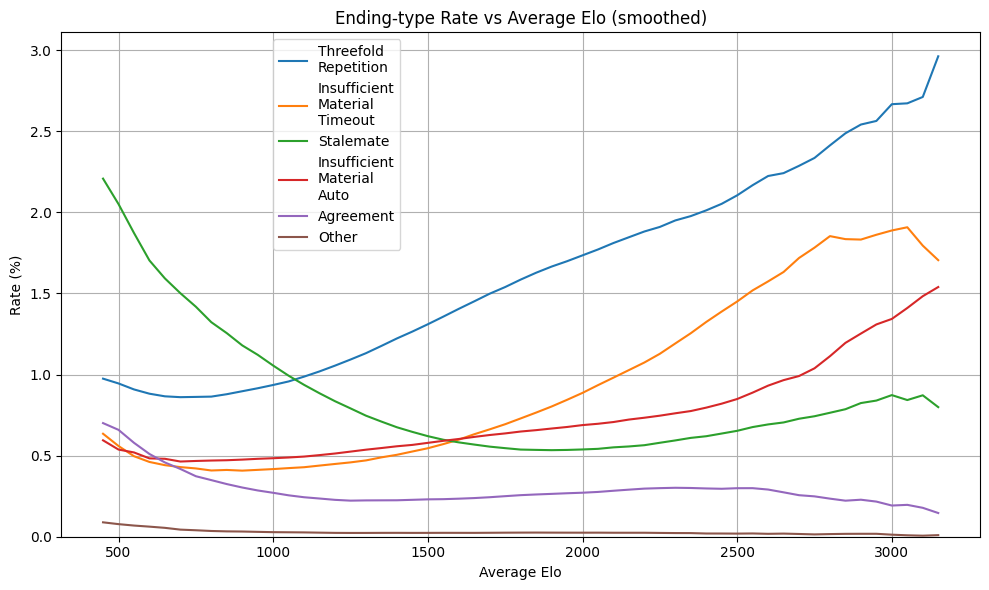

In [15]:
endings_map = {
    "threefold_repetition":"Threefold\nRepetition",
    "timeout_draw_by_insufficient":"Insufficient\nMaterial\nTimeout",
    "stalemate": "Stalemate",
    "insufficient_material_automatic":"Insufficient\nMaterial\nAuto",
    "agreement_draw": "Agreement",
    "other": "Other"
}

plot_selected_endings_vs_elo(
    con,
    endings_map,
    binsize=50,
    rolling_bins=11,
    min_games_per_bin=200,
    figsize=(10,6)
)


(Other is 1. the fifty move rule, and 2.insufficient material claimed, which is where a player with sufficient material to mate offers a draw to a player with insufficient material to mate and the draw is automatically accepted)

In [16]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN end_code = 5 THEN 1 ELSE 0 END AS was_stalemated,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(was_stalemated) AS stalemates,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_10124\584562980.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


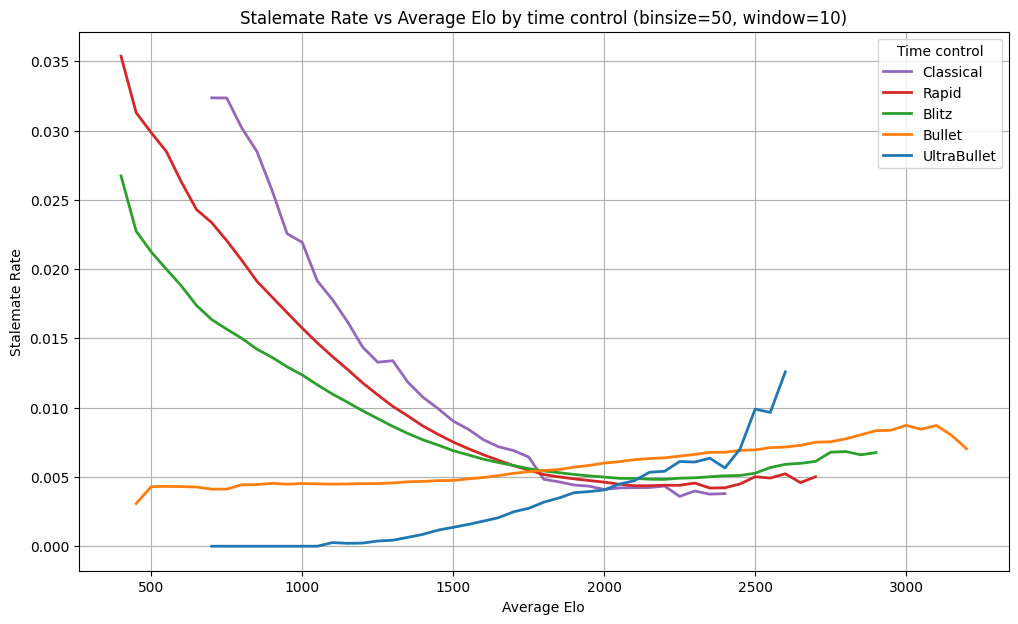

In [17]:
plot_separate_tc('stalemates', 'Stalemate Rate')

In [18]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN end_code = 6 THEN 1 ELSE 0 END AS was_threefold,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(was_threefold) AS threefolds,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_10124\584562980.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


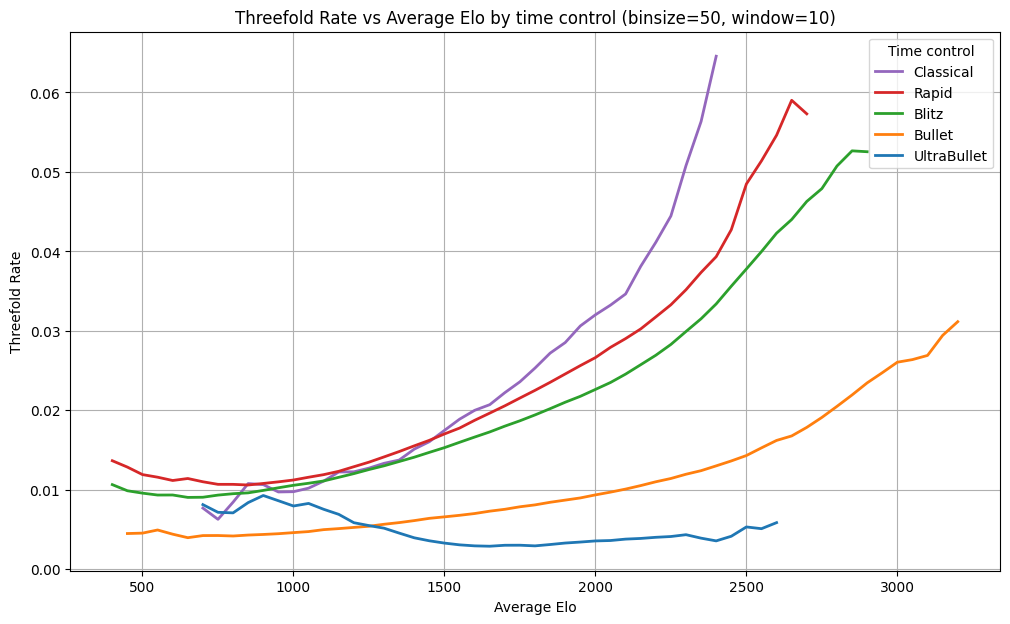

In [19]:
plot_separate_tc('threefolds', 'Threefold Rate')

In [20]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN end_code = 4 THEN 1 ELSE 0 END AS was_timeout_draw_by_insufficient,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(was_timeout_draw_by_insufficient) AS timeout_insufficients,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_10124\584562980.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


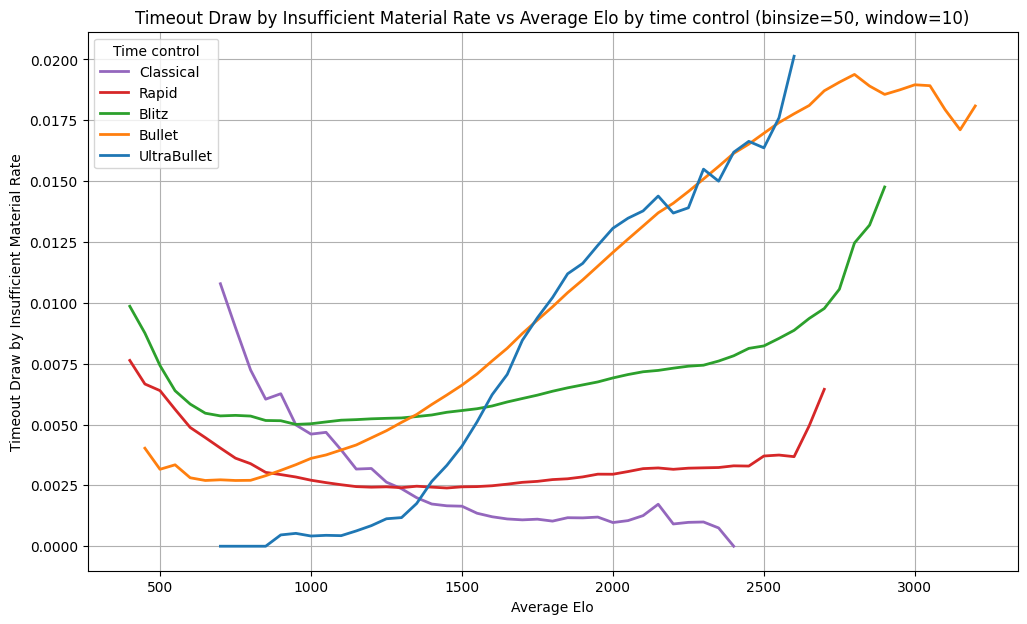

In [21]:
plot_separate_tc('timeout_insufficients', 'Timeout Draw by Insufficient Material Rate')

In [22]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN mated IS TRUE THEN 1 ELSE 0 END AS was_mated,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(was_mated) AS mates,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_10124\584562980.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


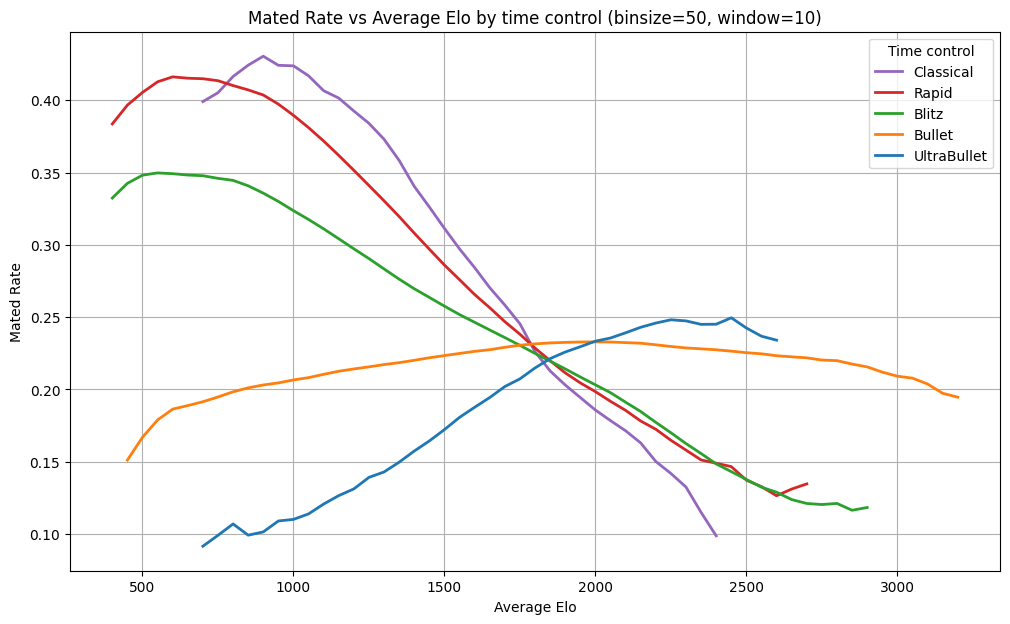

In [23]:
plot_separate_tc('mates', 'Mated Rate')

As somewhat expected for gamemodes where time is not so much of an issue, 

In [24]:
query = f"""
WITH tc AS (
  SELECT
    game_type AS time_control,
    ((white_elo + black_elo) / 2.0) AS avg_elo,
    CASE WHEN termination = 'Time forfeit' THEN 1 ELSE 0 END AS flag,
  FROM games_clean
)
SELECT
  time_control,
  CAST((avg_elo / {binsize}) AS INTEGER) * {binsize} AS elo_bin,
  COUNT(*) AS total_games,
  SUM(flag) AS flags,
FROM tc
GROUP BY time_control, elo_bin
ORDER BY time_control, elo_bin;
"""

df = con.execute(query).fetchdf()

C:\Users\sebeg\AppData\Local\Temp\ipykernel_10124\584562980.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df.groupby('time_control', group_keys=False).apply(lambda g: weighted_smooth_group(g, window=rolling_bins))


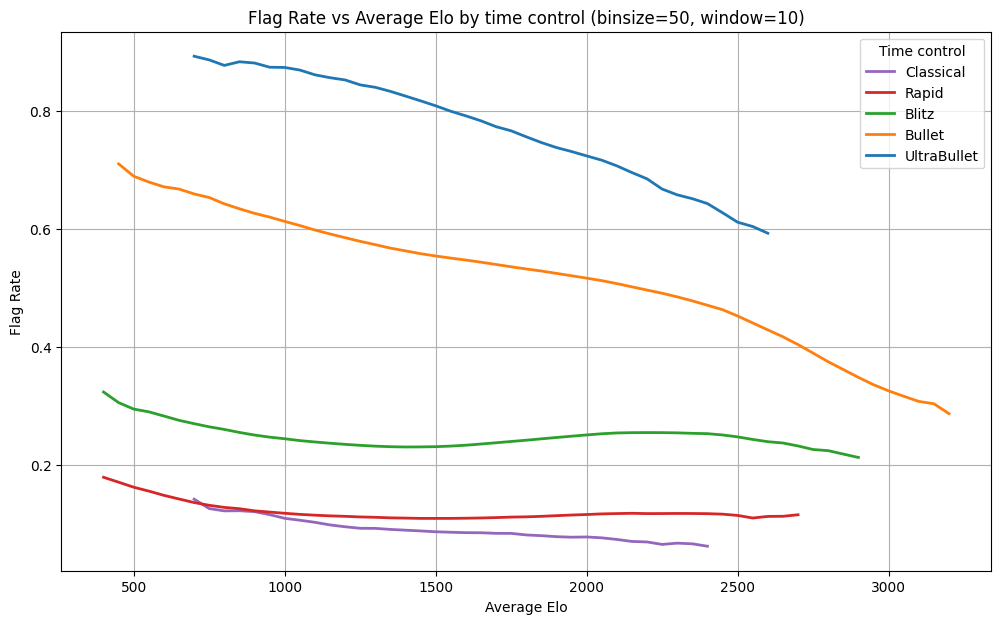

In [25]:
plot_separate_tc('flags', 'Flag Rate')

In [26]:
con.close()